In [293]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os
#Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, cross_val_predict, KFold
from sklearn.pipeline import make_pipeline
from pylab import rcParams
from sklearn.metrics import confusion_matrix

import data_preprocessing
%matplotlib inline
params = {'axes.labelsize': 14,'axes.titlesize':14, 'text.fontsize': 14, 'legend.fontsize': 14,
          'xtick.labelsize': 13, 'ytick.labelsize': 14}
rcParams['figure.figsize'] = 6.5, 4

matplotlib.rcParams.update(params)


/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:913: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [294]:
import imp
data_preprocessing = imp.reload(data_preprocessing)

In [69]:
output_path = "./Plots/"


In [70]:
data_original = pd.read_csv('./Data Mining VU data/training_set_VU_DM_2014.csv')

In [378]:
df = data_original.head(10000)


In [379]:
df_original = data_original.head(10000)

In [380]:
data = data_original.head(10000)

#  Feature Engineering

## Composite features
Rank by group
1. Extract season: autumn, summer, winter 


In [381]:
df['date_time']= pd.to_datetime(df['date_time'])
df = df.drop(['date_time'], axis=1)


/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Outliers
For features with high value outliers cap to maximum

In [382]:
all_cols = df.columns.drop(['booking_bool', 'click_bool', 'gross_bookings_usd', 'position'])


In [383]:
feature = 'price_usd'
df_before = df.copy()
for feature in all_cols:
    df[feature][df[feature]>df[feature].quantile(0.99)] = df[feature].quantile(0.99)


/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### NEW FEATURES

In [384]:
df['price_diff_from_historic_mean']= df.price_usd - df.visitor_hist_adr_usd

In [385]:
df['price_usd'].quantile(0.99)

602.770307

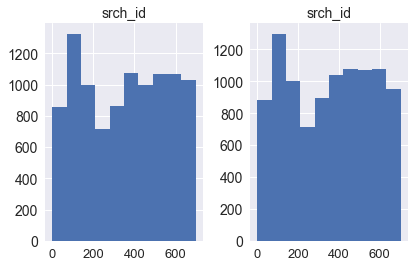

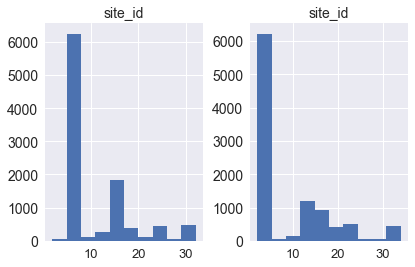

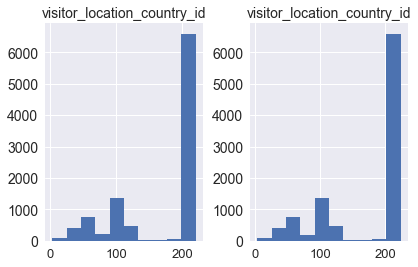

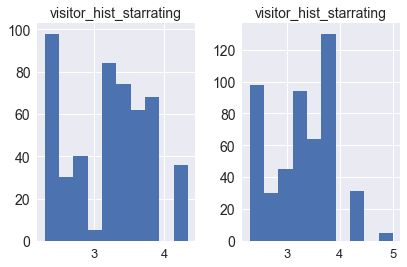

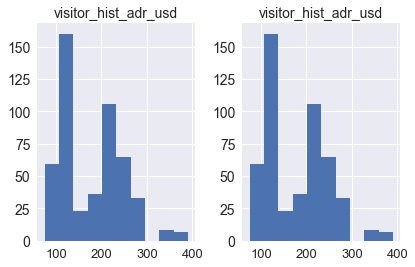

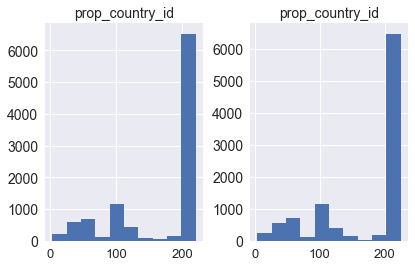

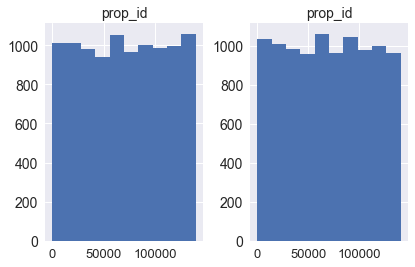

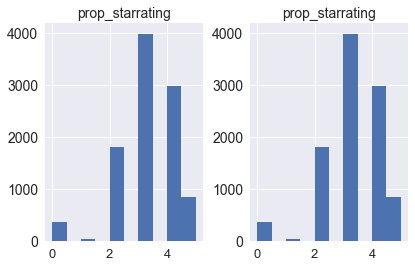

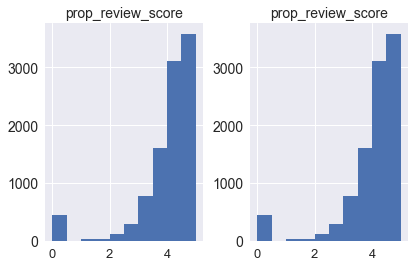

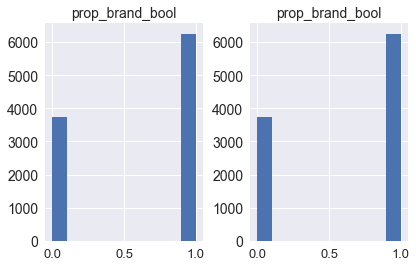

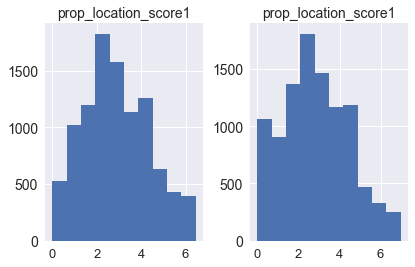

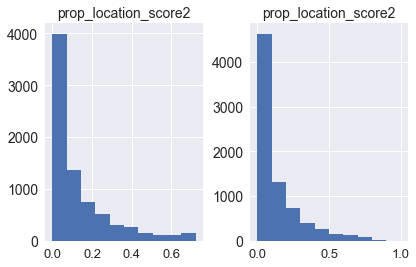

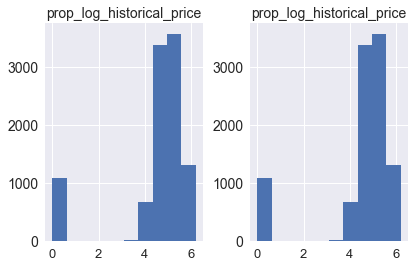

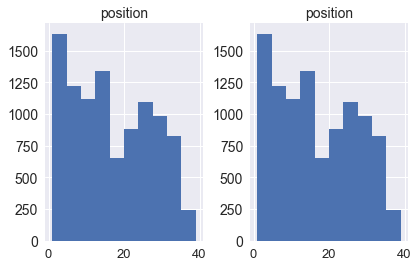

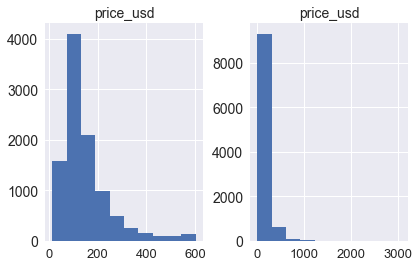

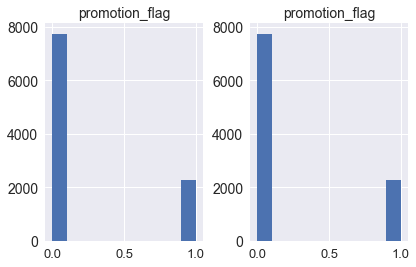

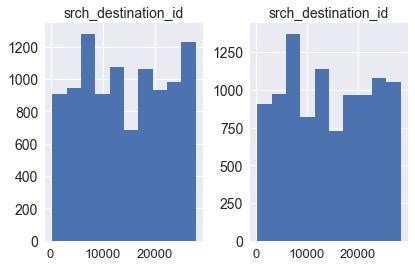

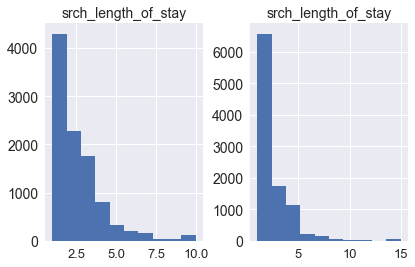

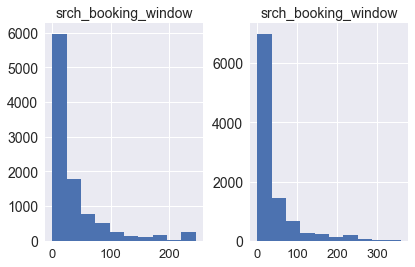

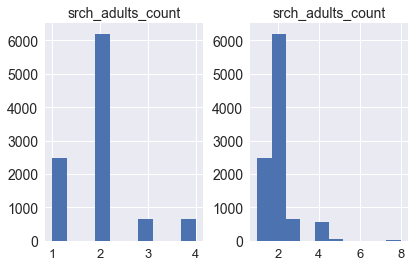

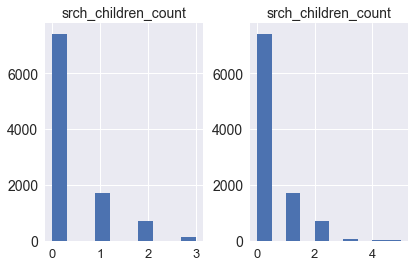

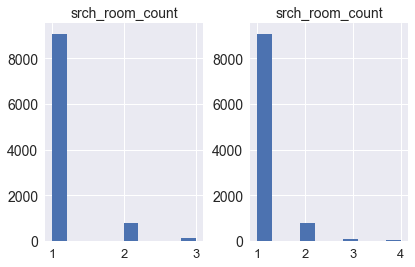

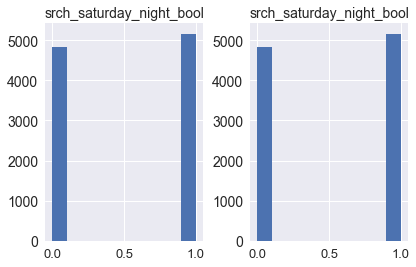

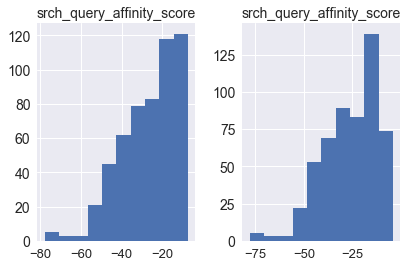

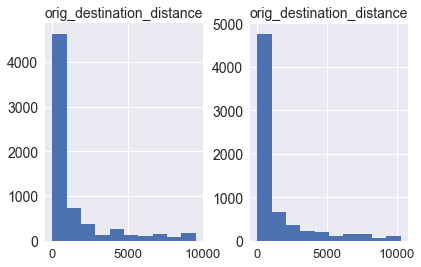

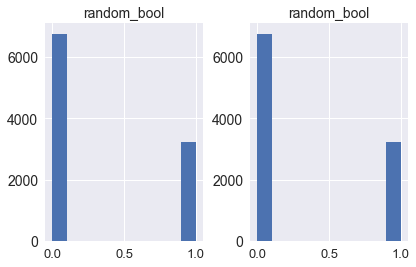

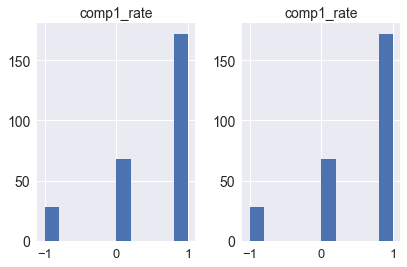

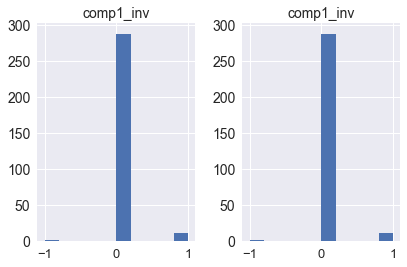

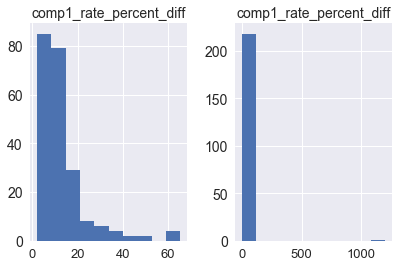

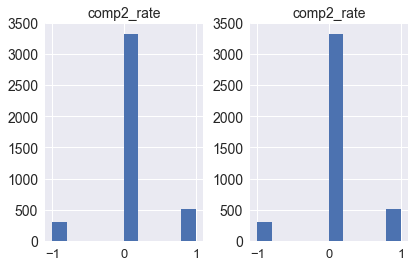

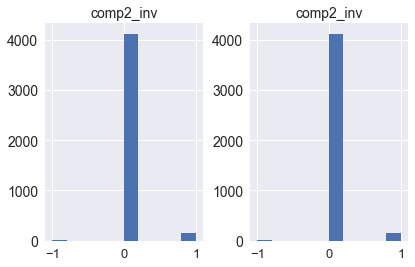

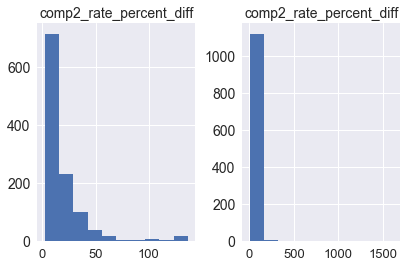

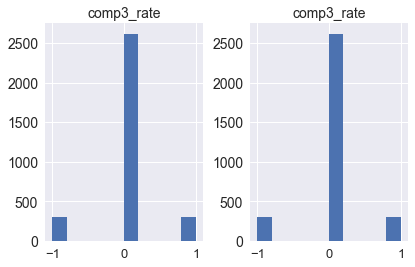

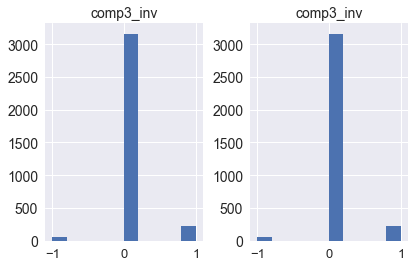

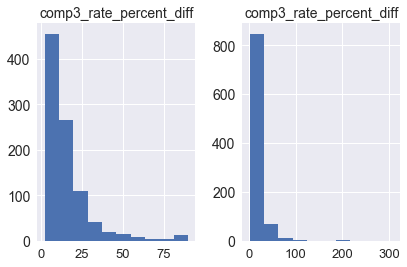

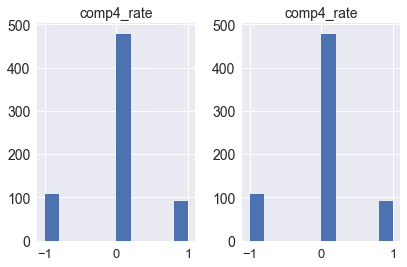

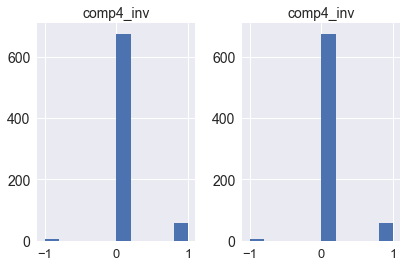

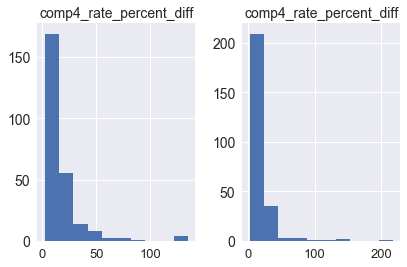

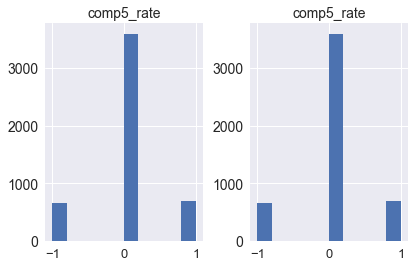

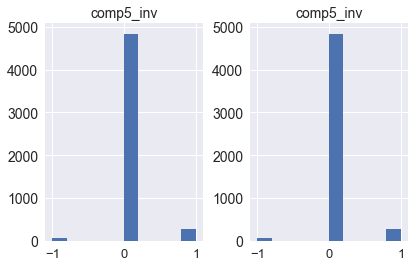

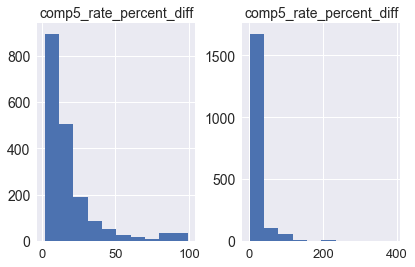

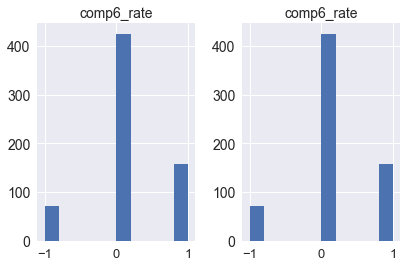

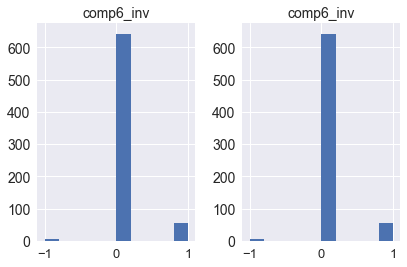

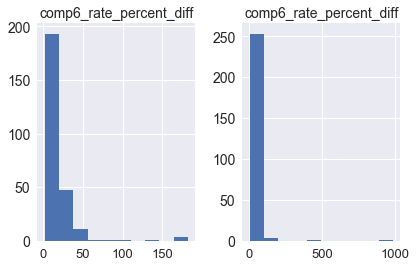

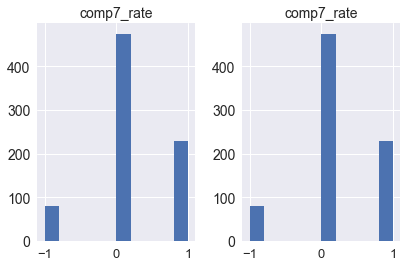

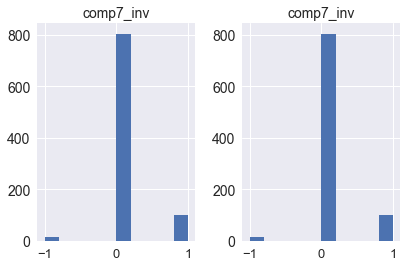

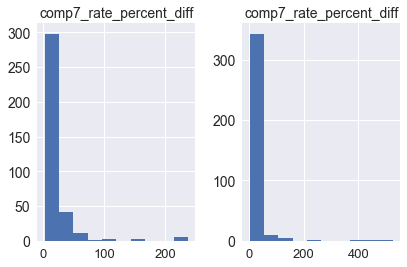

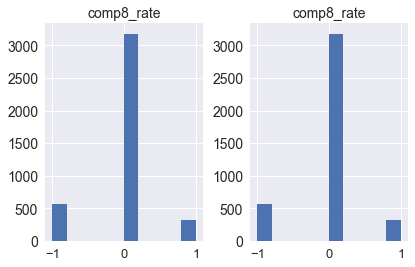

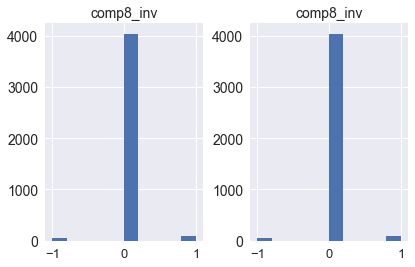

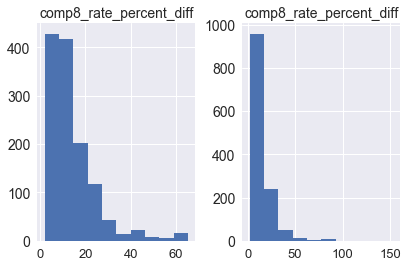

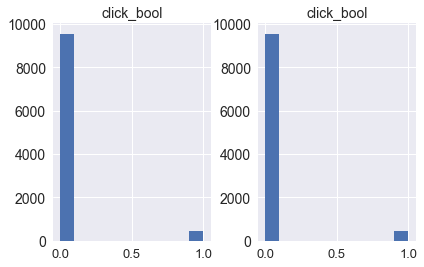

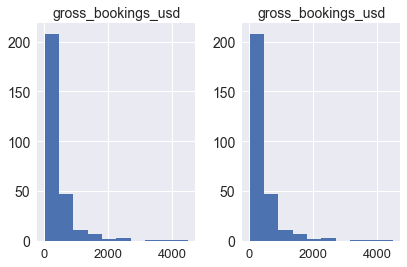

KeyError: "['price_diff_from_historic_mean'] not in index"

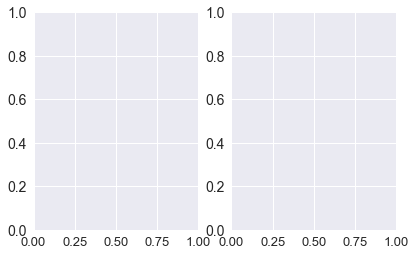

In [386]:
for feature in all_cols:
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)  
    df_before[[feature]].hist(bins=10, ax=ax2)
    df[[feature]].hist(bins=10, ax=ax1)
    plt.savefig(output_path + "hist_remove_outliers_%s.png"%feature, format='png')

    plt.show()



In [387]:
df = data_preprocessing.create_composite_features(df)
# Remove outliers before normalizing?
df = data_preprocessing.normalize_within_group(df)
    

In [ ]:
TO_DROP = ["visitor_hist_adr_usd"]

### Set Missing values to median

In [388]:
all_cols=df.columns.drop(['booking_bool', 'click_bool', 'gross_bookings_usd', 'position'])

for feature in all_cols:
    df[feature][df[feature].isnull()] = df[feature].median()


/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [389]:
# Subselect columns - include booking_book
summary_metrics = pd.DataFrame(df.describe())

In [390]:
df=df[list(summary_metrics.columns)]

In [391]:
summary_metrics

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,price_diff_from_historic_mean,price_rank,star_rank,value_for_money,price_usd_normalized,value_for_money_normalized
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,281.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,353.820500,9.943100,172.913600,3.259731,180.549116,171.313800,69980.065500,3.169400,3.782700,0.625200,...,11.373538,0.045700,409.795516,0.028100,-36.605528,12.177000,12.177000,0.033281,0.361397,0.468940
std,204.390114,7.514007,67.111343,0.127120,14.213314,69.676669,40572.454449,1.063681,1.034523,0.484095,...,4.006179,0.208844,551.617038,0.165267,19.657147,7.770644,7.770644,0.019192,0.280039,0.275583
min,1.000000,2.000000,4.000000,2.300000,74.790000,4.000000,1.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,26.460000,0.000000,-331.570000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,162.000000,5.000000,100.000000,3.260000,180.750000,100.000000,34802.000000,3.000000,3.500000,0.000000,...,11.000000,0.000000,125.210000,0.000000,-36.510000,6.000000,6.000000,0.020725,0.136584,0.259449
50%,365.000000,5.000000,219.000000,3.260000,180.750000,219.000000,69701.500000,3.000000,4.000000,1.000000,...,11.000000,0.000000,209.500000,0.000000,-36.510000,11.000000,11.000000,0.031646,0.294448,0.464747
75%,533.000000,14.000000,219.000000,3.260000,180.750000,219.000000,104517.000000,4.000000,4.500000,1.000000,...,11.000000,0.000000,490.360000,0.000000,-36.510000,18.000000,18.000000,0.043489,0.529888,0.670823
max,698.000000,32.000000,220.000000,4.337600,390.570000,220.000000,139249.310000,5.000000,5.000000,1.000000,...,65.260000,1.000000,4491.280000,1.000000,398.870700,61.000000,61.000000,0.284900,1.000000,1.000000


In [401]:
df.price_usd_normalized

0       0.037495
1       0.164998
2       0.182509
3       1.000000
4       0.112505
5       0.212505
6       0.085002
7       0.000000
8       0.125010
9       0.377503
10      0.202493
11      0.029996
12      0.029996
13      0.242501
14      0.102493
15      0.029996
16      0.129996
17      0.102493
18      0.057499
19      0.205006
20      0.072497
21      0.105006
22      0.057499
23      0.082509
24      0.185002
25      0.067491
26      0.037495
27      0.202493
28      0.424528
29      0.432075
          ...   
9970    0.124722
9971    0.274286
9972    0.370476
9973    0.146071
9974    0.268968
9975    0.250000
9976    0.297619
9977    0.158730
9978    0.281746
9979    0.250000
9980    0.162698
9981    0.126984
9982    0.146825
9983    0.146825
9984    0.484127
9985    0.087302
9986    0.361111
9987    0.178571
9988    0.075397
9989    0.206349
9990    0.242063
9991    0.400794
9992    0.277778
9993    0.063492
9994    0.126984
9995    0.313492
9996    0.103175
9997    0.2817

### Calculate correlation and mutual information/information gain

### Histograms

In [393]:
#columns_to_plot=[50,12,39,42,47,48,51,53]
#g = sns.pairplot( df.iloc[1:500,columns_to_plot], hue="booking_bool",palette = 'seismic',size=5,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10),  )


## HISTOGRAMS OF VARIABLES OF INTEREST

# for feature in data.columns:
#     try:
#         data[[feature]].hist(bins=10)
#         plt.title(feature)
#         plt.savefig(output_path + "hist_%s_original.png"%feature, format='png')
#         plt.show()

#     except:
#         pass

# for feature in df.columns:
#     try:
#         data[[feature]].hist(bins=10)
#         plt.title(feature)
#         plt.savefig(output_path + "hist_%s_new.png"%feature, format='png')
#         plt.show()

#     except:
#         pass




## Distribution of each feature for booked and not booked hotels
Helps find the most discriminative features

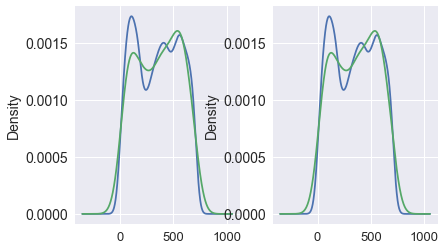

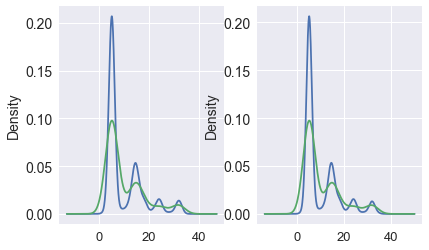

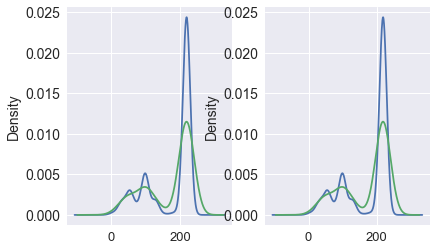

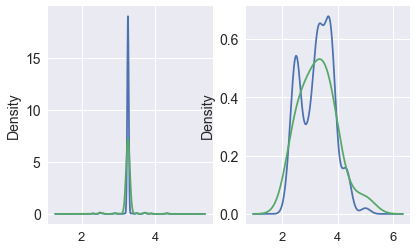

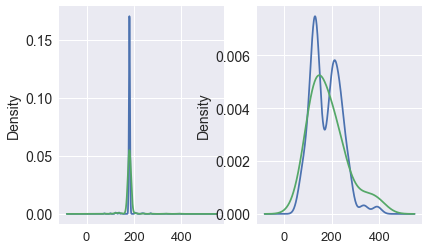

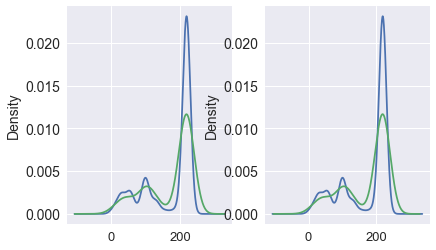

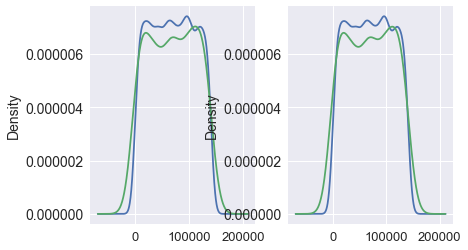

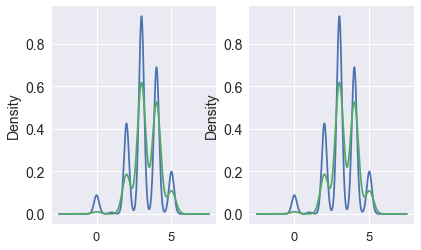

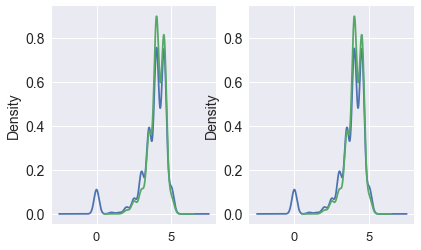

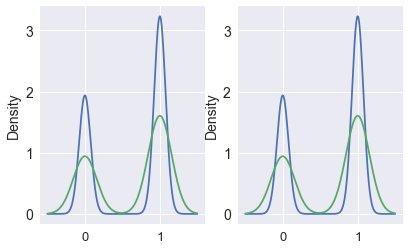

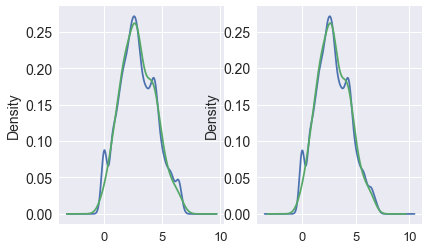

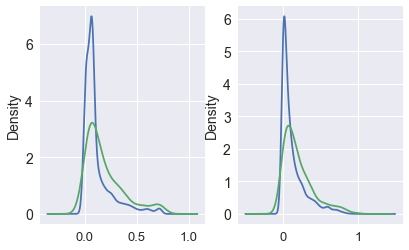

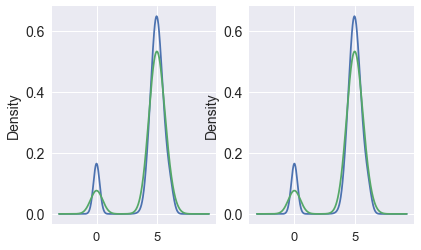

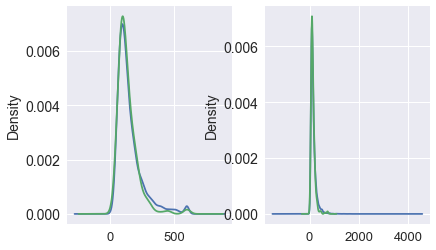

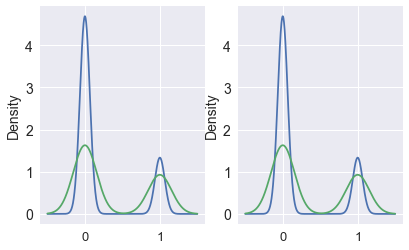

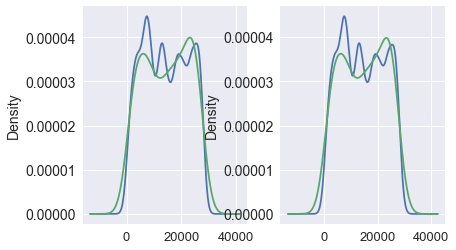

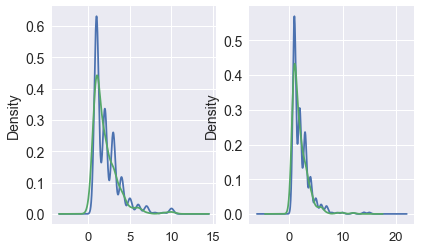

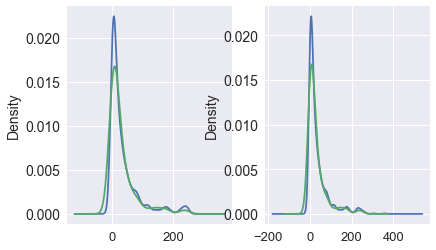

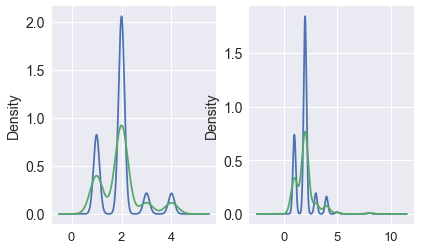

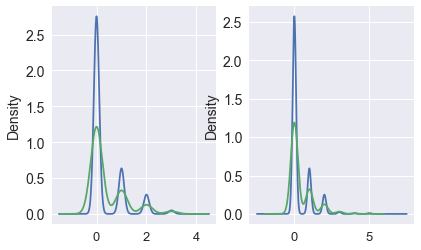

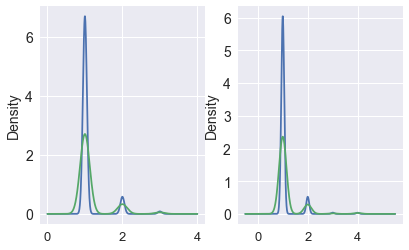

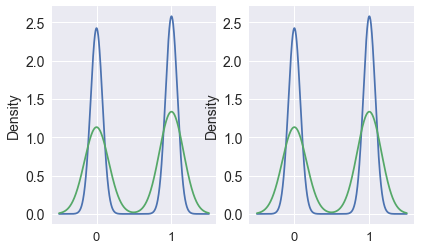

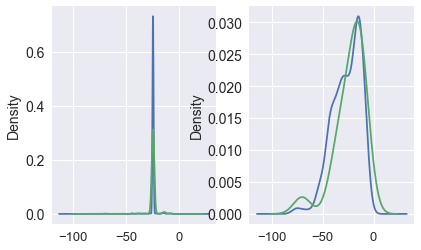

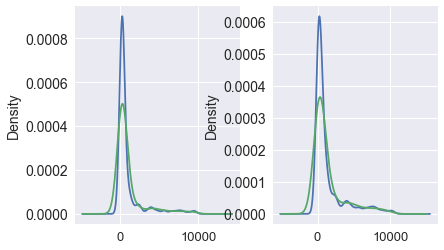

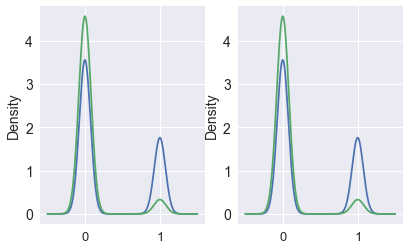

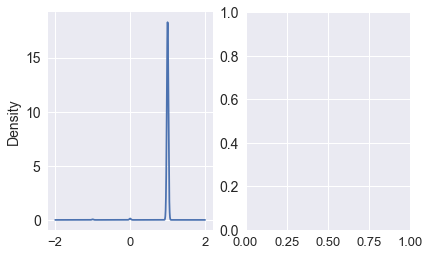

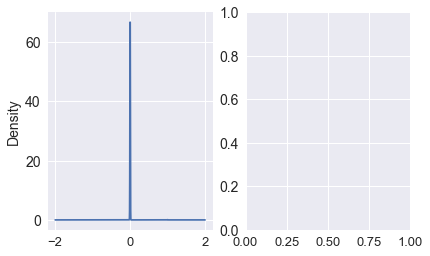

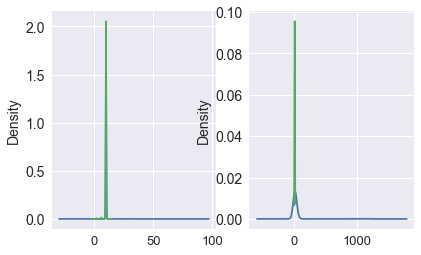

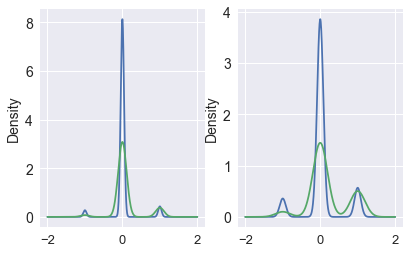

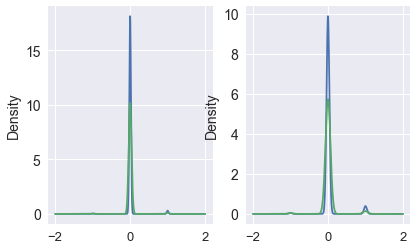

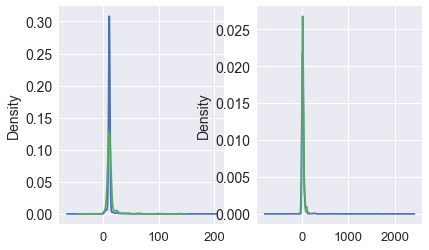

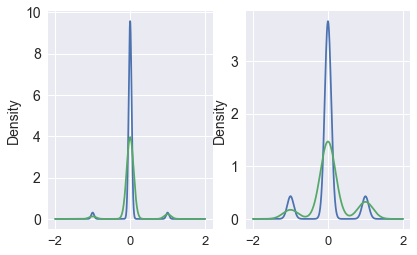

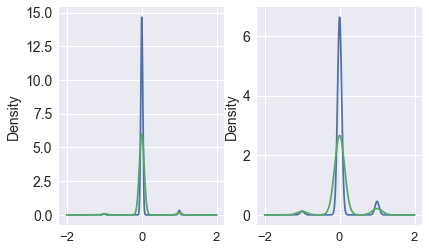

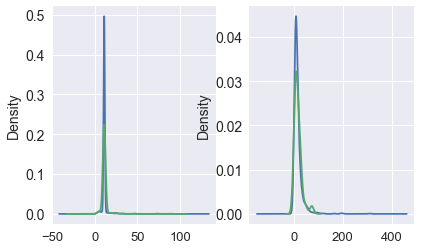

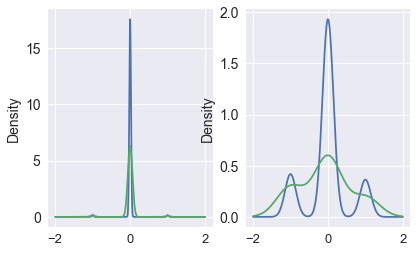

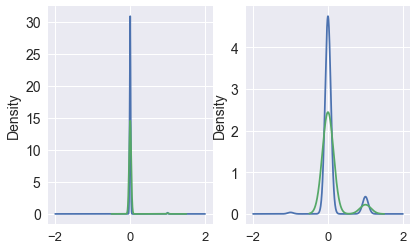

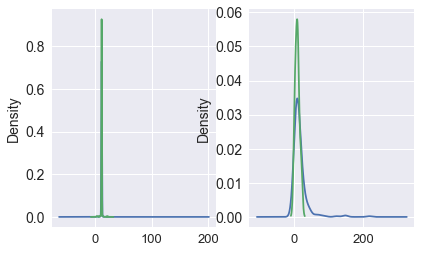

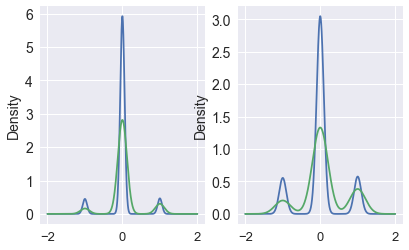

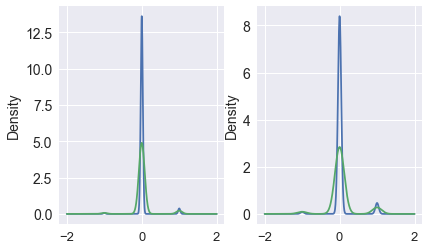

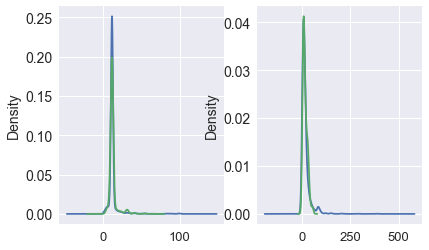

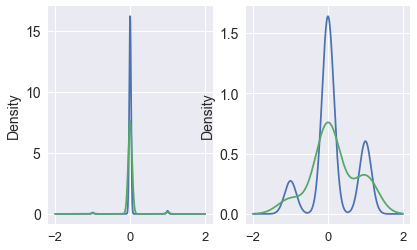

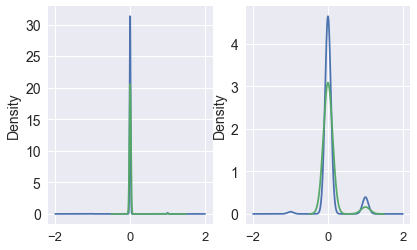

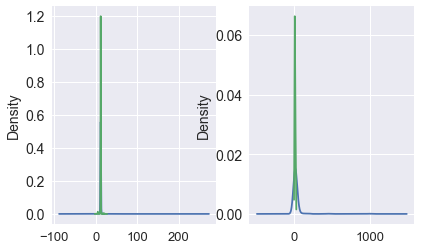

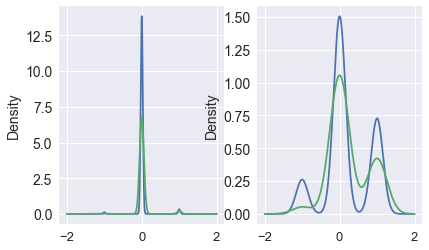

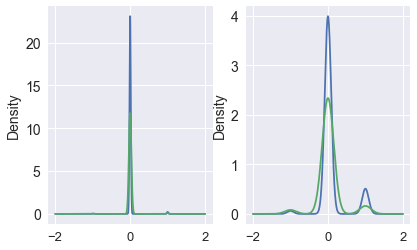

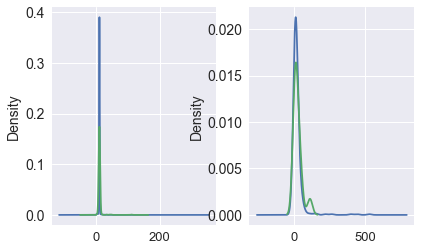

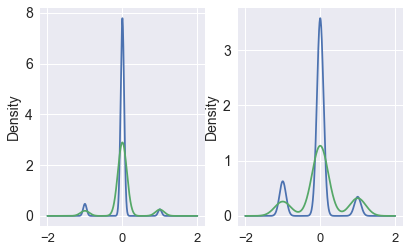

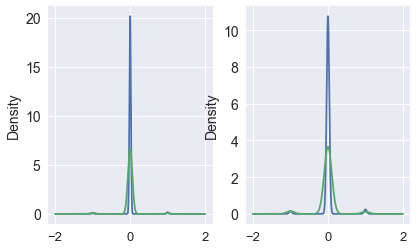

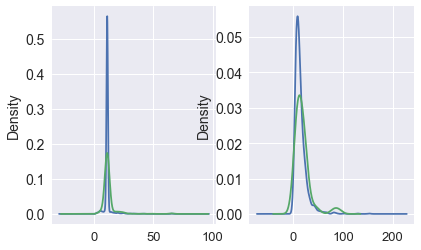

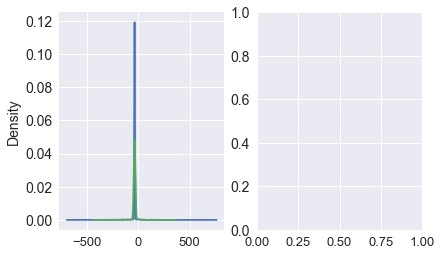

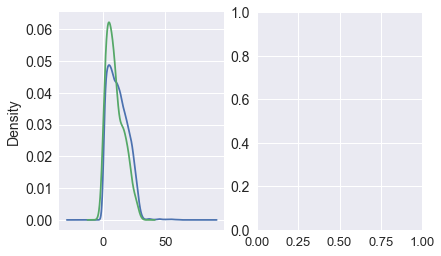

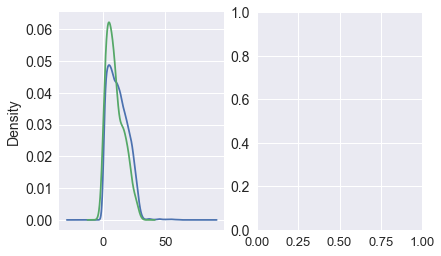

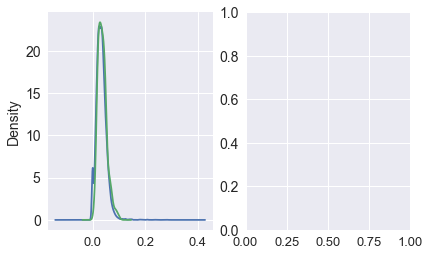

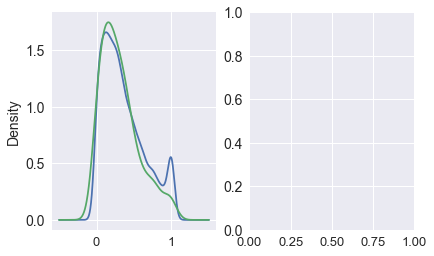

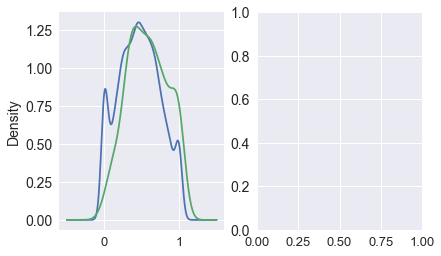

In [394]:
all_cols=df.columns.drop(['booking_bool', 'click_bool', 'gross_bookings_usd', 'position'])

for feature in all_cols:
    try:
        fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)  
        df.groupby("booking_bool")[feature].plot(kind='kde', ax=ax1)
        data.groupby("booking_bool")[feature].plot(kind='kde', ax=ax2)
        plt.savefig(output_path + "densityplot_before_after_%s.png"%feature, format='png')
        plt.show()
    except:
        pass


### Comments and Findings

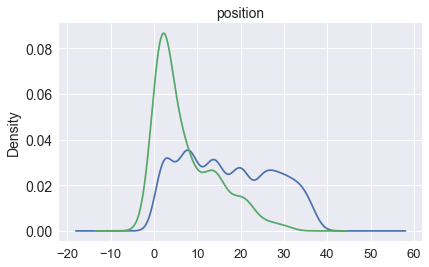

In [396]:
discriminative_features = ['position']

feature = discriminative_features[0]
df.groupby("booking_bool")[feature].plot(kind='kde')
plt.title(feature)
plt.show()

In [397]:
 all_cols

Index(['srch_id', 'site_id', 'visitor_location_country_id',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score',
       'orig_destination_distance', 'random_bool', 'comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv',
       'co

## Mutual information with booking 
Gives the most important features based on univariate statistics

In [398]:
all_cols = df.columns.drop(['booking_bool', 'click_bool', 'gross_bookings_usd', 'position'])


In [399]:
from sklearn.feature_selection import mutual_info_classif

mutual_information_click = mutual_info_classif(df[all_cols], df[['click_bool']], discrete_features='auto', n_neighbors=3, copy=True, random_state=None)
click_df = pd.DataFrame(mutual_information_click.flatten(), columns = ['mutual_info'])
click_df['feature'] = df[all_cols].columns.values

mutual_information_book = mutual_info_classif(df[all_cols], df[['booking_bool']], discrete_features='auto', n_neighbors=3, copy=True, random_state=None)
book_df = pd.DataFrame(mutual_information_book.flatten(), columns = ['mutual_info'])
book_df['feature'] = df[all_cols].columns.values



/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  after removing the cwd from sys.path.
/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """


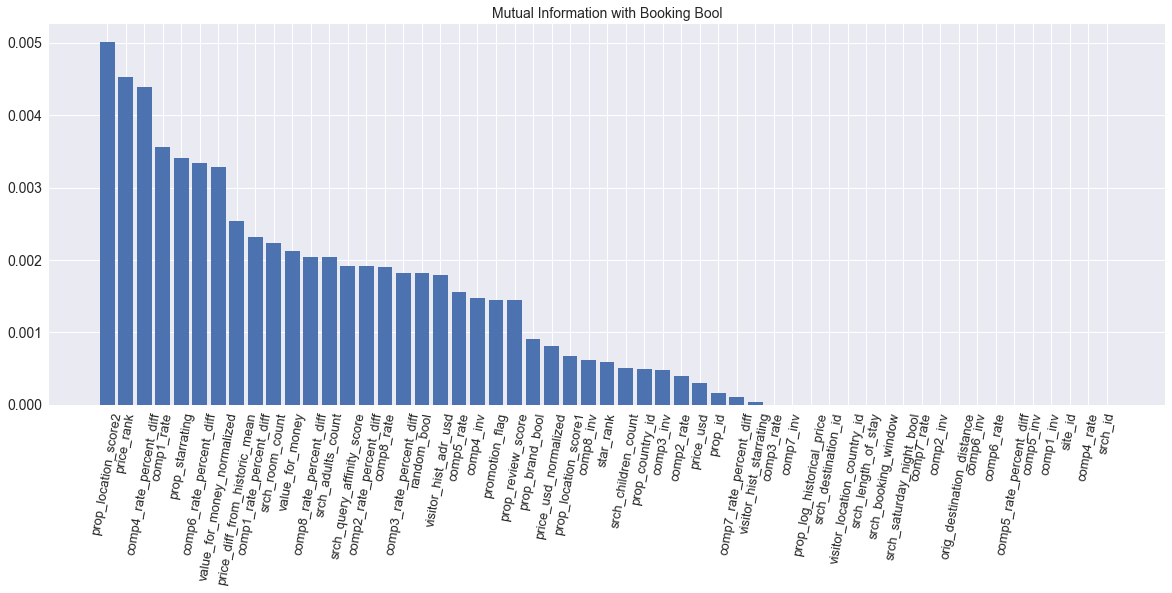

/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app
/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:16: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


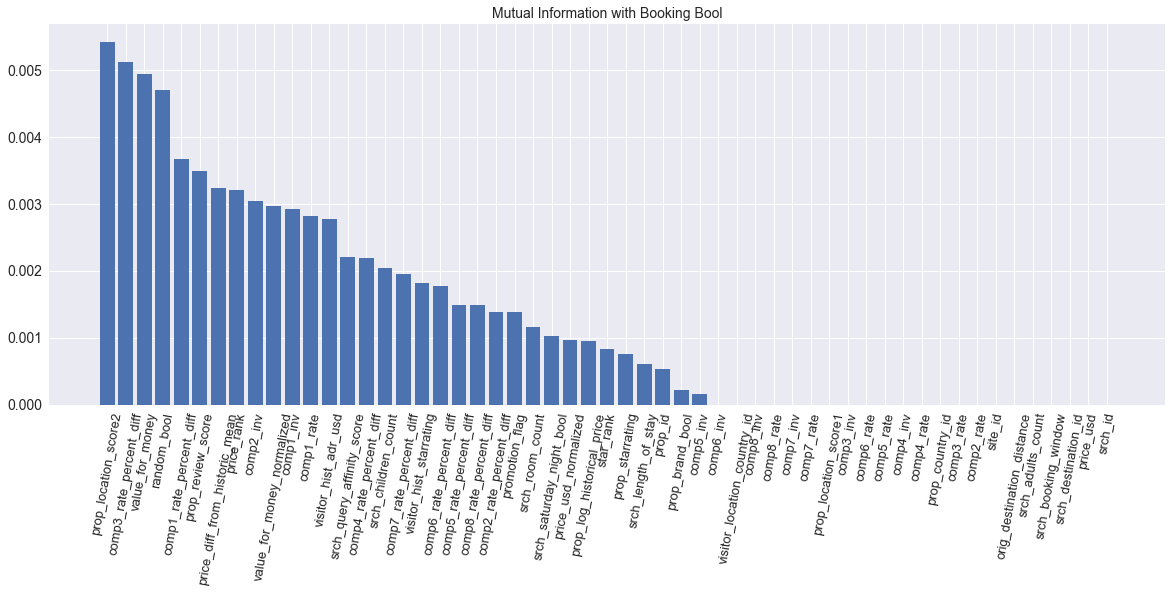

In [400]:
ind = np.arange(len(mutual_information_book))
fig, ax = plt.subplots(figsize=(20,7)) 

plt.bar(ind, click_df.sort('mutual_info', ascending=False)['mutual_info'])
plt.xticks(ind,click_df.sort('mutual_info', ascending=False)['feature'], rotation=80)
plt.title('Mutual Information with Booking Bool')
plt.savefig(output_path + "MutualInformation_click_bool.png", format='png')
plt.show()



ind = np.arange(len(mutual_information_click))
fig, ax = plt.subplots(figsize=(20,7)) 

plt.bar(ind, book_df.sort('mutual_info', ascending=False)['mutual_info'])
plt.xticks(ind,book_df.sort('mutual_info', ascending=False)['feature'], rotation=80)
plt.title('Mutual Information with Booking Bool')
plt.savefig(output_path + "MutualInformation_book_bool.png", format='png')
plt.show()

In [402]:
features_to_keep = ['booking_bool', 'click_bool', 'srch_id']
selected_features = ['value_for_money','value_for_money_normalized','price_usd', 'price_usd_normalized','price_rank', 'star_rank', 'prop_review_score', 'position',
                     'prop_brand_bool', 'prop_location_score1']

all_possible_features = selected_features+features_to_keep

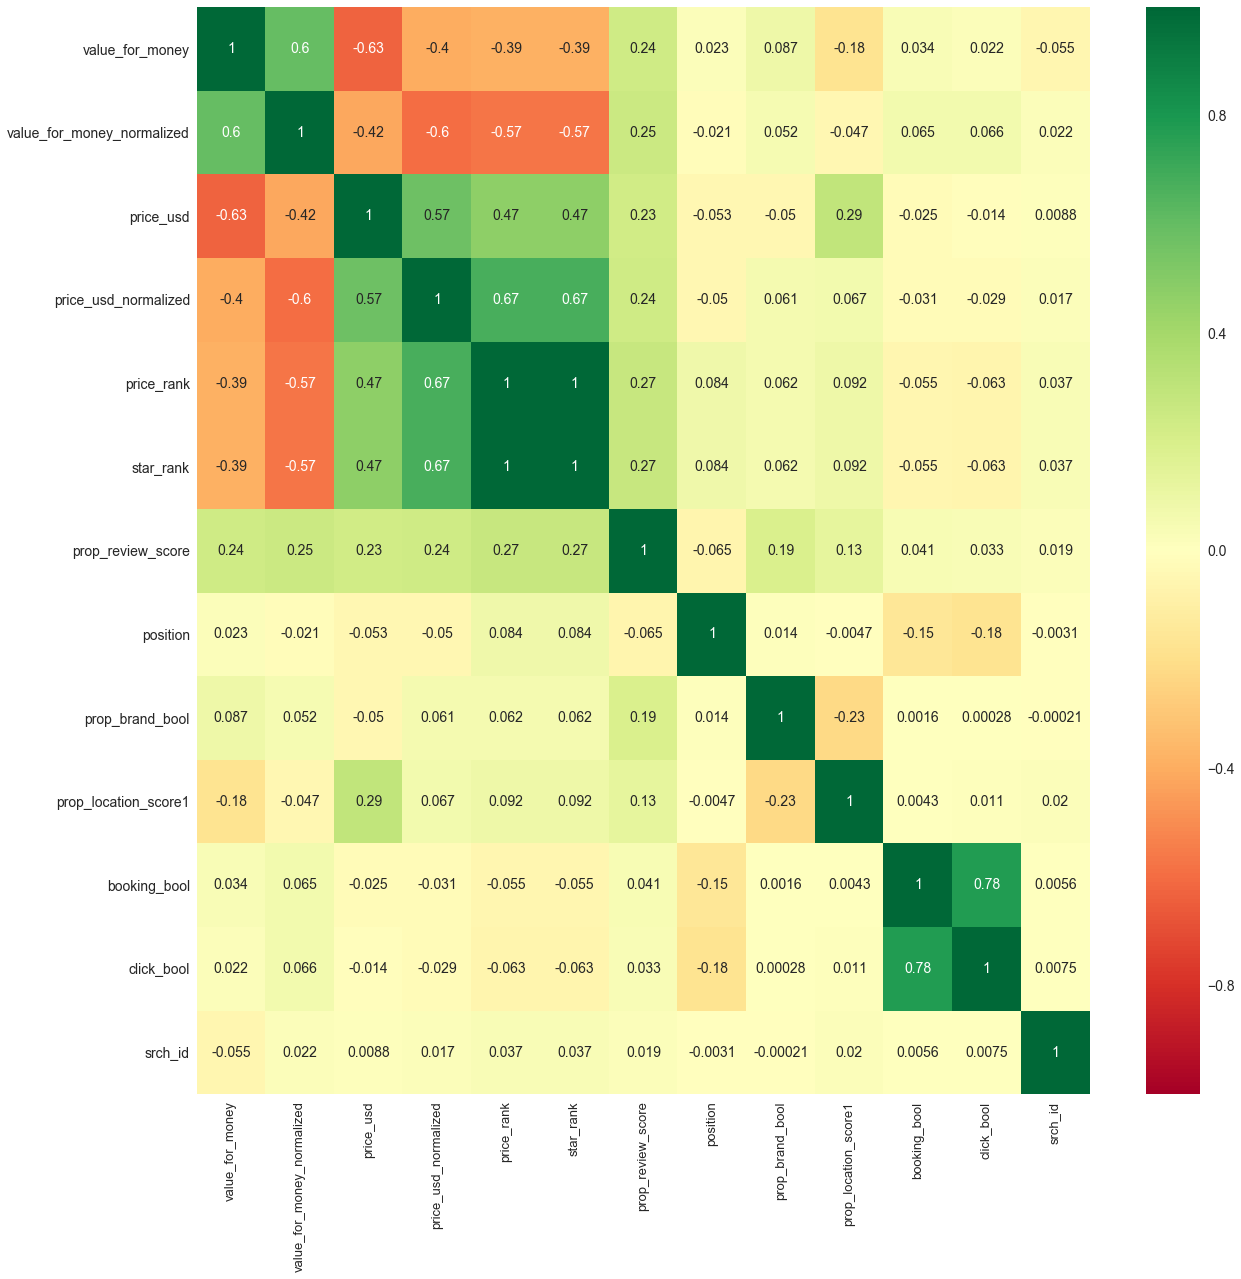

In [403]:
def plot_corr(data):
    correlation = data.corr()
    fig, ax = plt.subplots(figsize=(20,20)) 
    sns.heatmap(correlation, annot=True, cbar=True, cmap="RdYlGn")
    plt.savefig(output_path + "correlation_plot.png", format='png')

plot_corr(df[all_possible_features])





In [292]:
selected_features = ['value_for_money','price_usd_normalized', 'star_rank']
features_to_keep = ['booking_bool', 'click_bool', 'srch_id']
all_possible_features = selected_features+features_to_keep
df_to_train = df.ix[:,all_possible_features]

df_to_train['relevance']=df_to_train.booking_bool+df_to_train.click_bool

for feature in all_possible_features:
    df_to_train[feature][df_to_train[feature].isnull()] = df_to_train[feature].median()




/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [ ]:
relevance_arr = np.array(df_to_train.relevance)
feature_arr = np.array(df_to_train[selected_features])
id_arr = np.array(df_to_train.srch_id)

In [ ]:
import pyltr
metric = pyltr.metrics.NDCG(k=10)

model = pyltr.models.LambdaMART(
    metric=metric,
    n_estimators=1000,
    learning_rate=0.02,
    max_features=0.5,
    query_subsample=0.5,
    max_leaf_nodes=10,
    min_samples_leaf=64,
    verbose=1,
)

model.fit(feature_arr, relevance_arr, id_arr)

## Missing values

# Build Model and classifier

In [ ]:
## Finalise the dataset
final_df=df_to_train

# Choose setting 
mode = 'Full' # 'Full' or 'partial'
model_to_plot=0 # 0 or 1
mode = 'partial'

# For SVM use Age continuous as it can learn nonlinear relationships
#selected_features =["Pclass", "Sex", "Age*Class", "Fare_Per_Person", "hasCabin", 
#                    "Title","Survived",
#                   "Family_Size", "Embarked", "Age"]

select = ['booking_bool']
auc = []

models_names = [ 'LogisticRegression', 'RandomForestClassifier', 'KNeighborsClassifier' ]
metric = 'roc_auc'
cv=4
models = [ LogisticRegression,  RandomForestClassifier , SVC]


In [ ]:

model_to_plot = 1
class_predict = "booking_bool"
all_possible_features = selected_features       
for feature in all_possible_features:
    select.append(feature)
    print(select)
    full_set = final_df[select]

    # First split the data into train and test

    # Extract the train and test from the new data_frame
    cols = list(set(full_set.columns) - set([class_predict]))
    X_train = full_set[:][cols]
    y_train = full_set[:][class_predict]
    
        # Running some models, testing with small cross_validation and f1 metric (binary target) and running the prediction
    # with all the training set
    
    mscores = []
    lscores = ['f1','accuracy','recall','roc_auc']
    np.random.seed(42) # Reproducibility of results is very important!
    for elem in models:
        mscores2 = []
        model = elem()
        for sc in lscores:
            scores = cross_val_score(model, X_train, y_train, scoring=sc, cv=cv)
            #y_pred = cross_val_predict(model, X_train, y_train, scoring=sc, cv=cv)
            #conf_mat = confusion_matrix(y_train,y_pred)
            
            mscores2.append(np.mean(scores))
            mscores.append(mscores2)
       # model_predict(model, X_train, y_train, mode)       
    scores = pd.DataFrame(mscores, columns=lscores)
    print(scores.ix[model_to_plot,metric])
    auc.append(scores.ix[model_to_plot,metric])

plt.plot(auc)
plt.ylabel(metric)
plt.title(models_names[model_to_plot])
plt.xticks(np.arange(len(all_possible_features)), all_possible_features,  rotation=45)
plt.savefig(output_path + "auc_by_feature_%s_%s_cv%s.png"%(models_names[model_to_plot], mode, cv), format='png')
plt.tight_layout()  
plt.show()
    